In [6]:
train_sents = [s.lower().split() for s in ["we 'll always have Paris", 
                                           "I live in Germany",
                                           "He comes from Denmark",
                                           "The capital of Denmark is Copenhagen"]]

train_labels = [[0, 0, 0, 0, 1],
                [0, 0, 0, 1],
                [0, 0, 0, 1],
                [0, 0, 0, 1, 0, 1]]

assert all(len(train_sents[i]) == len(train_labels[i]) for i in range(len(train_sents)))

In [7]:
test_sents = [s.lower().split() for s in ["She comes from Paris"]]
test_labels = [[0, 0, 0, 1]]

assert all([len(test_sents[i]) == len(test_labels[i]) for i in range(len(test_sents))])

In [8]:
id_2_word = ["<pad>", "<unk>", "we", "always", "have", "paris",
             "i", "live", "in", "germany",
             "he", "comes", "from", "denmark",
             "the", "of", "is", "copenhagen"]

word_2_id = {w:i for i, w in enumerate(id_2_word)}

In [9]:
def convert_tokens_to_ids(sentence, word_2_id):
    return [word_2_id.get(token, word_2_id["<unk>"]) for token in sentence]

In [10]:
def pad_sentence_for_window(sentence, window_size, pad_token = "<pad>"):
    return [pad_token]*window_size + sentence + [pad_token]*window_size

In [12]:
window_size = 2

for sent in train_sents:
    tok_idxs = convert_tokens_to_ids(pad_sentence_for_window(sent, window_size), word_2_id)
    print([id_2_word[i] for i in tok_idxs])

['<pad>', '<pad>', 'we', '<unk>', 'always', 'have', 'paris', '<pad>', '<pad>']
['<pad>', '<pad>', 'i', 'live', 'in', 'germany', '<pad>', '<pad>']
['<pad>', '<pad>', 'he', 'comes', 'from', 'denmark', '<pad>', '<pad>']
['<pad>', '<pad>', 'the', '<unk>', 'of', 'denmark', 'is', 'copenhagen', '<pad>', '<pad>']


In [13]:
import pprint
pp = pprint.PrettyPrinter()

In [14]:
import torch

In [16]:
l = torch.LongTensor(train_labels[0])
pp.pprint(("raw label", l))
print(l.size())

('raw label', tensor([0, 0, 0, 0, 1]))
torch.Size([5])


In [19]:
from torch.utils.data import DataLoader
from functools import partial
import torch.nn as nn

In [32]:
def my_collate(data, window_size, word_2_id):
    
    x_s, y_s = zip(*data)
    
    window_padded = [convert_tokens_to_ids(pad_sentence_for_window(sent, window_size), word_2_id) 
                     for sent in x_s]
    
    padded = nn.utils.rnn.pad_sequence([torch.LongTensor(t) for t in window_padded], batch_first = True)
    
    labels = []
    lengths = []
    for y in y_s:
        lengths.append(len(y))
        label = torch.zeros((len(y), 2))
        true = torch.LongTensor(y) # [1, 0, 0]
        false = ~true.bool() # [0, 1, 1]
        label[:, 0] = false
        label[:, 1] = true
        labels.append(label)
    padded_labels = nn.utils.rnn.pad_sequence(labels, batch_first = True)
    
    return padded.long(), padded_labels, torch.LongTensor(lengths)

In [33]:
example_loader = DataLoader(list(zip(train_sents, train_labels)),
                            batch_size = 2,
                            shuffle = True,
                            collate_fn = partial(my_collate, window_size = 2, word_2_id = word_2_id))

# partial coz data given via dataloader formulation

In [34]:
for batched_input, batched_labels, batch_lengths in example_loader:
    pp.pprint(("inputs", batched_input, batched_input.size()))
    pp.pprint(("labels", batched_labels, batched_labels.size()))
    pp.pprint(("lengths", batch_lengths))
    break # coz this keeps on happening

('inputs',
 tensor([[0, 0, 2, 1, 3, 4, 5, 0, 0],
        [0, 0, 6, 7, 8, 9, 0, 0, 0]]),
 torch.Size([2, 9]))
('labels',
 tensor([[[1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [0., 1.]],

        [[1., 0.],
         [1., 0.],
         [1., 0.],
         [0., 1.],
         [0., 0.]]]),
 torch.Size([2, 5, 2]))
('lengths', tensor([5, 4]))


In [42]:
# now, we'd like to create context words + center word type vector
# for each B, for each word in sent of length L, need a 2m+1 vec
# => tensor of size (B, L, 2*m+1)

dummy_input = torch.zeros((2, 8)).long()
dummy_input[:, 2:-2] = torch.arange(1, 9).view(2, 4) # reshape 
pp.pprint(dummy_input)

dummy_output = [[[dummy_input[b, l -2 + k]
                for k in range(2*2 + 1)]
                for l in range(2, 6)]
                for b in range(2)]

dummy_output = torch.LongTensor(dummy_output)
pp.pprint(dummy_output)

tensor([[0, 0, 1, 2, 3, 4, 0, 0],
        [0, 0, 5, 6, 7, 8, 0, 0]])
tensor([[[0, 0, 1, 2, 3],
         [0, 1, 2, 3, 4],
         [1, 2, 3, 4, 0],
         [2, 3, 4, 0, 0]],

        [[0, 0, 5, 6, 7],
         [0, 5, 6, 7, 8],
         [5, 6, 7, 8, 0],
         [6, 7, 8, 0, 0]]])


In [43]:
dummy_input.unfold(1, 2*2 + 1, 1)

tensor([[[0, 0, 1, 2, 3],
         [0, 1, 2, 3, 4],
         [1, 2, 3, 4, 0],
         [2, 3, 4, 0, 0]],

        [[0, 0, 5, 6, 7],
         [0, 5, 6, 7, 8],
         [5, 6, 7, 8, 0],
         [6, 7, 8, 0, 0]]])

In [45]:
class SoftmaxWordWindowClassifier(nn.Module):
    
    def __init__(self, config, vocab_size, pad_idx = 0):
        super(SoftmaxWordWindowClassifier, self).__init__()
        
        self.window_size = 2 * config["half_window"] + 1
        self.embed_dim = config["embed_dim"]
        self.hidden_dim = config["hidden_dim"]
        self.num_classes = config["num_classes"]
        self.freeze_embeddings = config["freeze_embeddings"]
        
        self.embed_layer = nn.Embedding(vocab_size, self.embed_dim, padding_idx = pad_idx)
        if self.freeze_embeddings:
            self.embed_layer.weight.requires_grad = False
            
        self.hidden_layer = nn.Sequential(nn.Linear(self.window_size * self.embed_dim, self.hidden_dim),
                                          nn.Tanh())
        
        self.output_layer = nn.Linear(self.hidden_dim, self.num_classes)
        
        self.log_softmax = nn.LogSoftmax(dim = 2) # better computation
    
    def forward(self, inputs):
        """
        Let B := batch_size
            L := window-padded sentence length
            D := self.embed_dim
            S := self.window_size = 2*m + 1
            H := self.hidden_dim
        
        inputs: (B, L) tensor of token indices
        """
        B, L = inputs.size()
        
        token_windows = inputs.unfold(1, self.window_size, 1)
        _, adjusted_length, _ = token_windows.size()
        
        # do sanity checks
        assert token_windows.size() == (B, adjusted_length, self.window_size)
        
        """
        Embedding
        Takes in a torch.LongTensor of size (B, L~, S)
        Outputs a (B, L~, S*D) FloatTensor
        """
        embedded_windows = self.embed_layer(token_windows) # (B, L~, S, D)
        
        embedded_windows = embedded_windows.view(B, adjusted_length, -1) 
        # -1 => whatever is left over
        
        """
        Hidden Layer
        Takes in (B, L~, S*D) FloatTensor
        Outputs a (B, L~, H) FloatTensor
        """
        layer_1 = self.hidden_layer(embedded_windows)
        
        """
        Ouptut Layer
        Takes in (B, L~, H) FloatTensor
        Outputs a (B, L~, num_classes) FloatTensor
        """
        layer_2 = self.output_layer(layer_1)
        
        """
        Softmax Layer
        Outputs log-normalized scores
        """
        output = self.log_softmax(layer_2)
        
        return output

In [52]:
config = {"batch_size": 4,
          "half_window": 2,
          "embed_dim": 25,
          "hidden_dim": 25,
          "num_classes": 2,
          "freeze_embeddings": False,
         }

learning_rate = 0.0002
num_epochs = 10000
model = SoftmaxWordWindowClassifier(config, len(word_2_id))
# pad_idx given to be 0 already
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

In [53]:
def loss_function(outputs, labels, lengths):
    
    B, L, num_classes = outputs.size()
    num_elems = lengths.sum().float() # from dataloader
    
    loss = outputs * labels # only at non zero labels?!
    
    return -loss.sum() / num_elems

In [54]:
def train_epoch(loss_function, optimizer, model, train_data):
    
    total_loss = 0
    for batch, labels, lengths in train_data:
        # clear grads
        optimizer.zero_grad()
        outputs = model.forward(batch)
        loss = loss_function(outputs, labels, lengths)
        # pass grads backward
        loss.backward()
        # update params
        optimizer.step()
        total_loss += loss.item()
        
    return total_loss

In [55]:
train_loader = torch.utils.data.DataLoader(list(zip(train_sents, train_labels)),
                                           batch_size = 2,
                                           shuffle = True,
                                           collate_fn = partial(my_collate, window_size = 2, word_2_id = word_2_id))

In [ ]:
losses = []

for epoch in range(num_epochs):
    epoch_loss = train_epoch(loss_function, optimizer, model, train_loader)
    if epoch % 100 == 0:
        #print("EPOCH --", epoch)
        losses.append(epoch_loss)
        
print(losses)

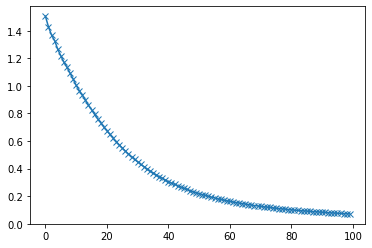

In [62]:
import matplotlib.pyplot as plt

plt.plot(range(len(losses)), losses, "x-")
plt.show()

In [57]:
test_loader = torch.utils.data.DataLoader(list(zip(test_sents, test_labels)), 
                                           batch_size=1, 
                                           shuffle=False, 
                                           collate_fn=partial(my_collate, window_size=2, word_2_id=word_2_id))

In [59]:
for test_instance, labs, _ in test_loader:
    outputs = model.forward(test_instance)
    print(outputs)
#     print(torch.argmax(outputs, dim=2))
#     print(torch.argmax(labs, dim=2))

tensor([[[-0.0454, -3.1151],
         [-0.0482, -3.0568],
         [-0.1176, -2.1991],
         [-3.2123, -0.0411]]], grad_fn=<LogSoftmaxBackward>)
